In [1]:
from pysbjupyter.pysb_models.lopez_embedded import model
import pysbjupyter as viz
from pysbjupyter.pysbviz import pysbViz
import numpy as np
from pysb.simulator import ScipyOdeSimulator
import os
import pandas as pd

In [2]:
pars = np.load('calibrated_6572pars.npy')
pars0 = pars[0]
tspan = np.linspace(0, 20000, 100)
sim = ScipyOdeSimulator(model, tspan, compiler='python').run(param_values=pars0)

In [3]:
pysbViz(data=sim, type_of_viz='dynamic_view', layout_name='cose-bilkent')

pysbViz(data=<pysb.simulator.base.SimulationResult object at 0x1522042668>, layout_name='cose-bilkent', type_o…

In [4]:
from scipy.optimize import curve_fit

def sig_apop(t, f, td, ts):
    """

    Parameters
    ----------
    t : list-like
        Time variable in the function
    f : float
        is the fraction cleaved at the end of the reaction
    td : float
        is the delay period between TRAIL addition and half-maximal substrate cleavage
    ts : float
        is the switching time between initial and complete effector substrate  cleavage

    Returns
    -------

    """
    return f - f / (1 + np.exp((t - td) / (4 * ts)))

#     xdata: list-like,
#         x-axis data points (usually time span of the simulation)
#     ydata: list-like,
#         y-axis data points (usually concentration of species in time)

c = curve_fit(f=sig_apop, xdata=tspan, ydata=sim.all['cPARP'], p0=[10,10,10])


In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
pars_for_kd = np.copy(pars0)
pars_for_kd[56] = pars_for_kd[56] * 0
sim_kd_bclxl = ScipyOdeSimulator(model, tspan, compiler='python').run(param_values=pars_for_kd)

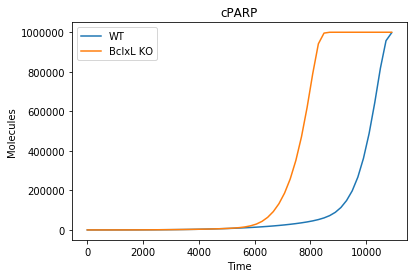

In [7]:
plt.plot(tspan[:55], sim.all['cPARP'][:55], label='WT')
plt.plot(tspan[:55], sim_kd_bclxl.all['cPARP'][:55], label='BclxL KO')
plt.xlabel('Time')
plt.ylabel('Molecules')
plt.title('cPARP')
plt.legend()
# plt.savefig('bclxl_ko.png', dpi=500, bbox_inches='tight')

In [8]:
pars2 = pars[9]
sim2 = ScipyOdeSimulator(model, tspan, compiler='python').run(param_values=pars2)

In [9]:
viz.sp_dyn_view(sim2)

pysbViz(data=<pysb.simulator.base.SimulationResult object at 0x15244ec208>, layout_name='preset', type_of_viz=…

In [10]:
pars_for_bcl2_kd = np.copy(pars2)
pars_for_bcl2_kd[57] = pars_for_bcl2_kd[57] * 0
sim_kd_bcl2 = ScipyOdeSimulator(model, tspan, compiler='python').run(param_values=pars_for_bcl2_kd)

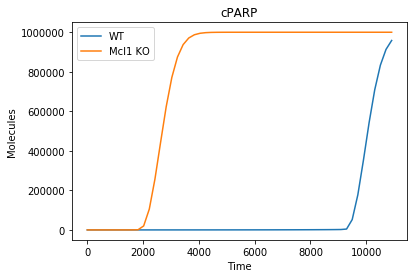

In [11]:
plt.plot(tspan[:55], sim2.all['cPARP'][:55], label='WT')
plt.plot(tspan[:55], sim_kd_bcl2.all['cPARP'][:55], label='Mcl1 KO')
plt.xlabel('Time')
plt.ylabel('Molecules')
plt.title('cPARP')
plt.legend()
# plt.savefig('Mcl1_ko.png', dpi=500, bbox_inches='tight')

In [12]:
# load experimental data
data_path = os.path.join(os.path.abspath(''), 'earm_data',
                         'EC-RP_IMS-RP_IC-RP_data_for_models.csv')

exp_data = pd.read_csv(data_path, index_col=False)
# Mean and variance of Td (delay time) and Ts (switching time) of MOMP, and
# yfinal (the last value of the IMS-RP trajectory)
momp_data = np.array([9810.0, 180.0, model.parameters['Smac_0'].value])
momp_var = np.array([7245000.0, 3600.0, 1e4])


In [13]:
def display(position, save_name):
    param_values = position
    traj = solver.run(param_values=param_values)

    # normalize trajectories
    bid_traj = traj.observables['mBid'] / model.parameters['Bid_0'].value
    cparp_traj = traj.observables['cPARP'] / model.parameters['PARP_0'].value
    aSmac_traj = traj.observables['aSmac'] / model.parameters['Smac_0'].value

    # create all plots for each observable
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9, 3), sharex=True, sharey=True)

    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.xlabel("Time(s)")
    plt.ylabel("Population")
    
    # plot cleaved parp
    ax[0].plot(tspan, bid_traj, color='r', marker='^', label='tBID sim')
    ax[0].errorbar(exp_data['# Time'], exp_data['norm_IC-RP'],
                 yerr=exp_data['nrm_var_IC-RP'] ** .5,
                 ecolor='black', color='black', elinewidth=0.5, capsize=0)
    ax[0].legend(loc=2)

    # plot cleaved parp
    ax[1].plot(tspan, cparp_traj, color='blue', marker='*', label='cPARP sim')
    ax[1].errorbar(exp_data['# Time'], exp_data['norm_EC-RP'],
                 yerr=exp_data['nrm_var_EC-RP'] ** .5,
                 ecolor='black', color='black', elinewidth=0.5, capsize=0)
    ax[1].legend(loc=2)

    # plot activated SMAC
    ax[2].plot(tspan, aSmac_traj, color='g', label='aSMAC sim')
    ax[2].axvline(momp_data[0], -0.05, 1.05, color='black', linestyle=':',
                label='exp aSMAC')
    ax[2].legend(loc=2)
#     fig.savefig('{}.png'.format(save_name), dpi=500, bbox_inches='tight')
#     plt.close()

2019-02-27 15:07:44.228 - pysb.simulator.scipyode - WARNING - [pysbjupyter.pysb_models.lopez_embedded] This system of ODEs will be evaluated in pure Python. This may be slow for large models. We recommend installing a package for compiling the ODEs to C code: 'weave' (recommended for Python 2) or 'cython' (recommended for Python 3). This warning can be suppressed by specifying compiler_mode='python'.


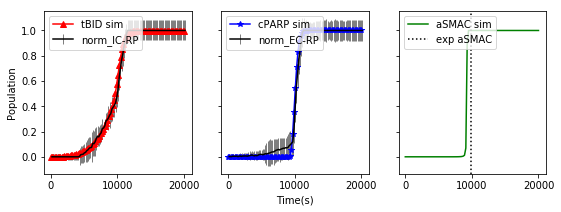

In [14]:
solver = ScipyOdeSimulator(model, tspan)
display(pars2, 'earm_mcl1')